In [1]:
import sys
import os
sys.path.append(os.path.abspath('../../'))

from rcgp.morcgp import MOGPRegressor, MORCGPRegressor, MOGPRegressor_NC, MORCGPRegressor_NC, MORCGPRegressor_NC_fixed_weights, MORCGPRegressor_fixed_weights, MORCGPRegressor_PM
from rcgp.rcgp import RCGPRegressor
from rcgp.kernels import ConstantMean, RBFKernel, SineMean
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams.update({
    "text.usetex": True,         
    "font.family": "serif",       
    "text.latex.preamble": r"\usepackage{amsmath}",
    'font.size': 24,         
    'axes.labelsize': 24,    
    'xtick.labelsize': 24,   
    'ytick.labelsize': 24,  
    'legend.fontsize': 20,
    'lines.linewidth': 4,    
    'lines.markersize': 5   
})

## Simulation

Methods for simulation

In [2]:
def train_test_split_random(x, Y, N_train):
    total_samples = x.shape[0]
    all_indices = np.arange(total_samples)
    
    # Randomly select training indices without replacement
    train_indices = np.random.choice(all_indices, size=N_train, replace=False)
    test_indices = np.setdiff1d(all_indices, train_indices)
    
    # Sort indices (optional, for consistent ordering)
    train_indices = np.sort(train_indices)
    test_indices = np.sort(test_indices)
    
    # Create splits
    x_train = x[train_indices]
    Y_train = Y[train_indices]
    x_test = x[test_indices]
    Y_test = Y[test_indices]
    
    return x_train, Y_train, x_test, Y_test

def introduce_missing_values(Y, missing_percentage):
    # Flatten the array and get total number of elements
    num_elements = Y.size
    num_nan = int(missing_percentage * num_elements)

    # Randomly choose indices to set to NaN
    nan_indices = np.random.choice(num_elements, num_nan, replace=False)

    # Flatten Y to 1D, copy it to avoid modifying the original
    Y_flat = Y.flatten().copy()

    # Replace selected indices with NaN
    Y_flat[nan_indices] = np.nan

    # Reshape back to original shape and return
    return Y_flat.reshape(Y.shape)

def rbf_kernel(x1, x2, lengthscale=1.0, variance=1.0):
    sqdist = np.sum(x1**2, 1).reshape(-1,1) + np.sum(x2**2,1) - 2*np.dot(x1, x2.T)
    return variance * np.exp(-0.5 / lengthscale**2 * sqdist)

Simulation and plotting

[10  4  9 10 12]


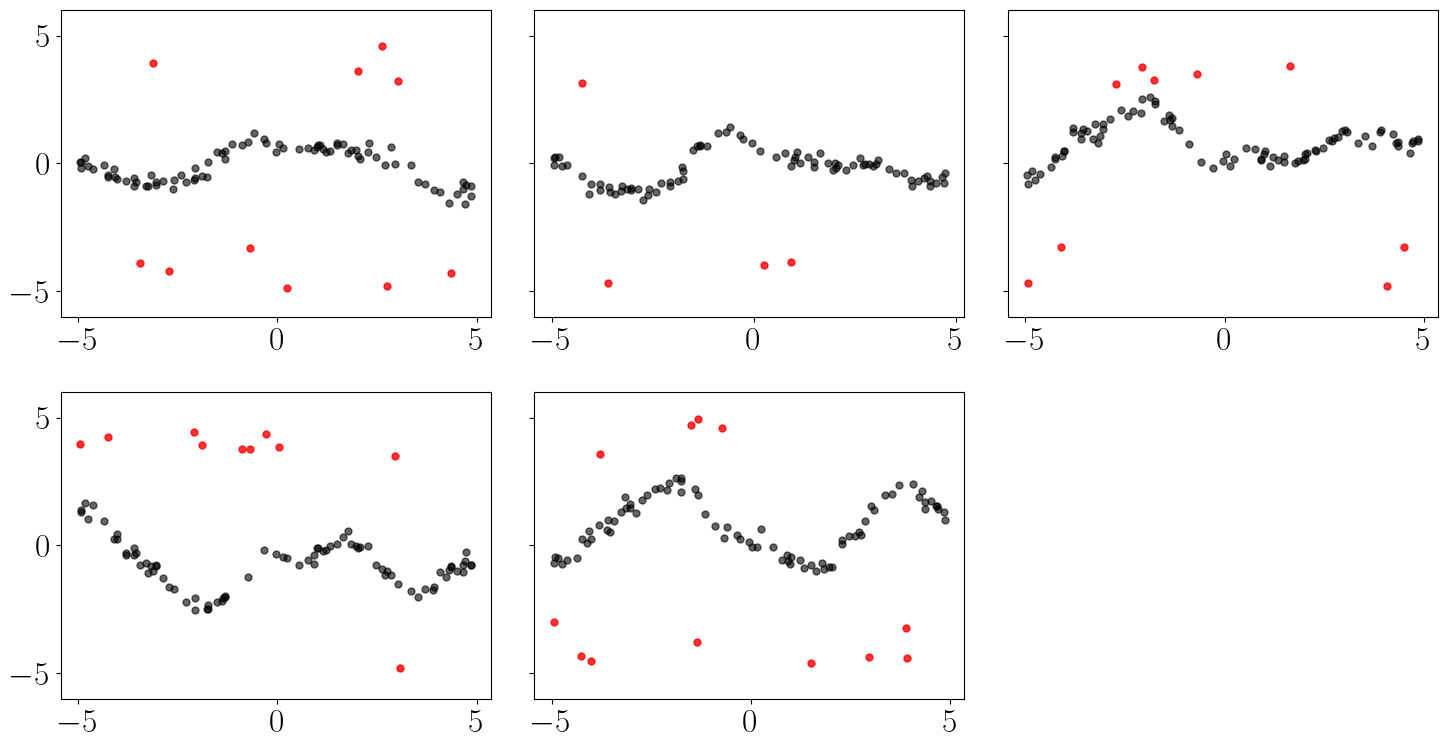

In [26]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import cholesky

np.random.seed(42)
train_test_N = 300
N = 100
D = 5  # changed to 5 outputs
noise_var = 0.2
missing_percentage = 0.1 
epsilon = 0.1

lengthscale = 1.0
rbf_variance = 1.0

x = np.sort(np.random.uniform(-5, 5, train_test_N)).reshape(-1, 1)

# Define a 5x5 coregionalization matrix B (symmetric and PSD)
B = np.array([
    [1.0,  0.9,  -0.7,  0.5,  -0.6],
    [0.9,  1.0,  -0.8,  0.6,  -0.7],
    [-0.7, -0.8,  1.0, -0.9,   0.8],
    [0.5,  0.6,  -0.9,  1.0,  -0.85],
    [-0.6, -0.7,  0.8, -0.85,  1.0]
])

A = np.linalg.cholesky(B)

Kx = rbf_kernel(x, x, lengthscale=lengthscale, variance=rbf_variance)
K = np.kron(B, Kx)

# Add a small jitter for numerical stability
L = cholesky(K + 1e-6*np.eye(D*train_test_N), lower=True)

f_samples = L @ np.random.randn(D*train_test_N)
F = f_samples.reshape(D, train_test_N).T
Y = F + np.random.normal(0, noise_var, F.shape)

x_train, Y_train, x_test, Y_test = train_test_split_random(x, Y, N)
Y_train = introduce_missing_values(Y_train, missing_percentage)

# Add 5% outliers uniformly distributed in [-4, -2] ∪ [2, 4]
num_outliers = int(epsilon * N * D * (1 - missing_percentage))
# num_outliers = 0
indices = np.unravel_index(np.random.choice(N * D, num_outliers, replace=False), (N, D))
uniform_outliers = np.random.uniform(0, 1, num_outliers)
outlier_values = np.where(
    uniform_outliers < 0.5,
    np.random.uniform(3, 5, num_outliers),
    np.random.uniform(-5, -3, num_outliers)
)
Y_train[indices] = outlier_values

# # Add outliers to Y_test
# num_outliers_test = int(epsilon * N * D * (1 - missing_percentage))
# indices_test = np.unravel_index(np.random.choice(N * D, num_outliers_test, replace=False), (N, D))
# uniform_outliers_test = np.random.uniform(0, 1, num_outliers_test)
# outlier_values_test = np.where(
#     uniform_outliers_test < 0.5,
#     np.random.uniform(3, 5, num_outliers_test),
#     np.random.uniform(3, 5, num_outliers_test)
# )
# Y_test[indices_test] = outlier_values_test

outliers_per_channel = np.bincount(indices[1])
non_nan_counts = np.sum(~np.isnan(Y_train), axis=0)

epsilons = outliers_per_channel / non_nan_counts

print(outliers_per_channel)

# Plotting in 2 rows and 3 columns
fig, axs = plt.subplots(2, 3, figsize=(15, 8))

# Flatten the indices for convenient comparison
outlier_mask = np.zeros((N, D), dtype=bool)
outlier_mask[indices] = True

for i in range(D):
    ax = axs[i // 3, i % 3]
    
    # Separate inliers and outliers
    x_all = x_train.flatten()
    y_all = Y_train[:, i]
    is_outlier = outlier_mask[:, i]

    ax.plot(x_all[~is_outlier], y_all[~is_outlier], 'o', color='black', alpha=0.6, label=f'Output {i+1} - inliers')
    ax.plot(x_all[is_outlier], y_all[is_outlier], 'o', color='red', alpha=0.8, label='Outliers')

    ax.set_ylim([-6, 6])
    if i % 3 != 0:
        ax.set_yticklabels([])

# Hide the unused 6th subplot
axs[1, 2].axis('off')

plt.tight_layout()
plt.show()

## MOGP

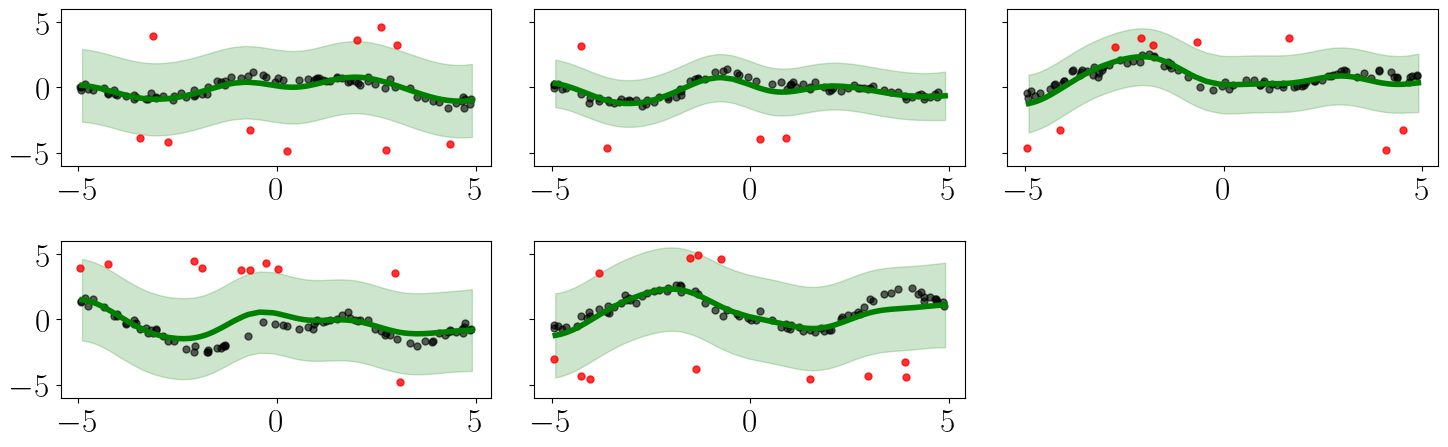

In [17]:
mogp = MOGPRegressor(mean=0, length_scale=1.0, noise = np.array([0.2] * D), A = 2*A)
# mogp = MOGPRegressor_NC(mean=0, length_scale=1.0, noise = 0.2, A = 2*A)
mogp.fit(x_train, Y_train)

mogp.optimize_hyperparameters(
    # print_opt_param=True, print_iter_param=True
    )
# mogp.optimize_loo_cv(print_opt_param=True, print_iter_param=True)

optim_A = mogp.A
optim_noise = mogp.noise
optim_B = optim_A @ optim_A.T
optim_length_scale = mogp.length_scale

# Predict on test points
mu_mogp, var_mogp = mogp.predict(x_test)
std_mogp = np.sqrt(var_mogp + mogp.noise)

# Plotting
fig, axs = plt.subplots(2, 3, figsize=(15, 5))

for i in range(D):
    ax = axs[i // 3, i % 3]
    # Separate inliers and outliers
    x_all = x_train.flatten()
    y_all = Y_train[:, i]
    is_outlier = outlier_mask[:, i]

    ax.plot(x_all[~is_outlier], y_all[~is_outlier], 'o', color='black', alpha=0.6, label=f'Output {i+1} - inliers')
    ax.plot(x_all[is_outlier], y_all[is_outlier], 'o', color='red', alpha=0.8, label='Outliers')
    ax.plot(x_test.flatten(), mu_mogp[:, i], '-', color='Green', label=f'Predicted Mean')
    ax.fill_between(x_test.flatten(), mu_mogp[:, i] - 2*std_mogp[:, i], mu_mogp[:, i] + 2*std_mogp[:, i], color='Green', alpha=0.2, label=f'±2 Std. Dev.')
    ax.set_ylim([-6, 6])
    if i % 3 != 0:
        ax.set_yticklabels([])

# Hide the unused 6th subplot
axs[1, 2].axis('off')

plt.tight_layout()
plt.show()

## MORCGP

-794.1300796869483
-794.130079438081
-794.1300785481124
-794.130079560861
-794.1300791764507
-794.1300779108057
-794.1300776612092
-794.1300796993032
-794.1300796652617
-794.1300796713658
-794.1300796928588
-794.1300796968571
-794.1300796644358
-794.1300796996313
-794.1300797003619
-794.1300796559887
-794.1300796809543
-794.1300796624552
-794.1300796744121
-794.1300796695084
-794.1300796798936
-794.1300796706774
-794.1300796686512
-794.1300796635572
-794.1300796408167
-794.1300796842031
-794.1300797144074
-794.1300796744016
-794.130079668214
-794.1300796745063
-794.1300796599913
-794.1300797456879
-588.8515318713086
-588.8515319758001
-588.8515312453528
-588.8515317653386
-588.8515315115621
-588.8515311139025
-588.8515310696152
-588.8515318713764
-588.8515318560025
-588.8515318451815
-588.8515318847022
-588.8515318706957
-588.851531844118
-588.8515318843755
-588.8515318733618
-588.8515318262665
-588.8515318530896
-588.8515318418542
-588.8515318586933
-588.8515318372592
-588.85153185036

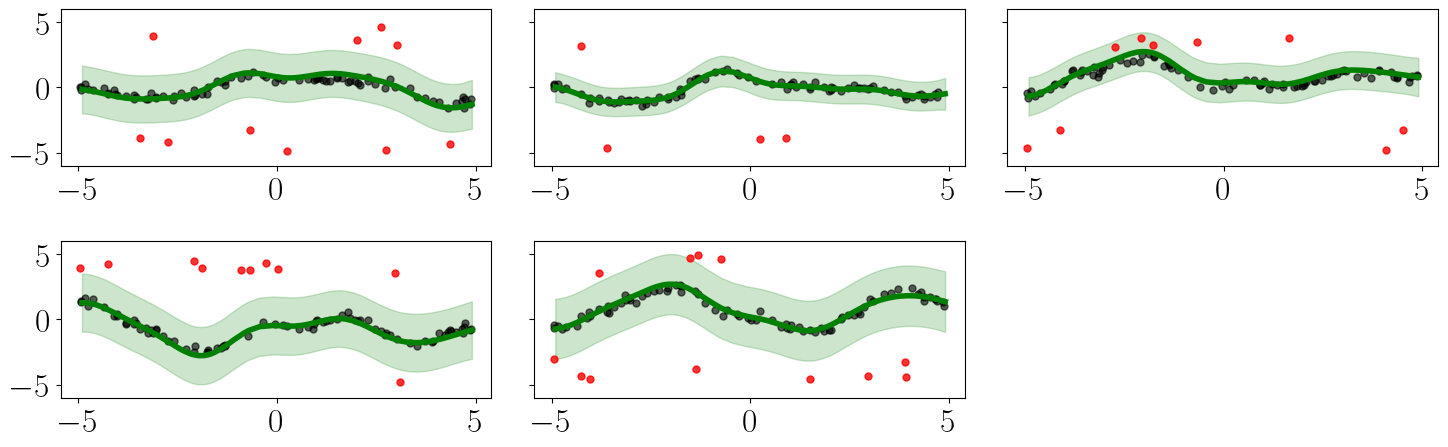

In [18]:
# morcgp = MORCGPRegressor_NC_fixed_weights(mean = 0, length_scale=optim_length_scale, noise = optim_noise, A=A)
morcgp = MORCGPRegressor_fixed_weights(mean = 0, length_scale=lengthscale, noise = np.array([0.2]*D), A=A)
# morcgp = MORCGPRegressor(mean=0, length_scale=lengthscale, noise=np.array([0.2]*D), A=A)
initial_predictive_mean, initial_predictive_variances = morcgp.fit(x_train, Y_train, 
                                                                   B_weighted=optim_B, noise_weighted=optim_noise
                                                                   )

# print(morcgp.loo_cv(length_scale=optim_length_scale, noise=optim_noise, A=A, weighted=False))

# Optimize hyperparameters
predictive_mean, predictive_variances = morcgp.optimize_loo_cv(weighted=True, print_opt_param = True, print_iter_param=True, update_weights=True
                                                            #    B_weighted=A@A.T, noise_weighted=np.array([0.2]*D)
                                                               )

mu_morcgp, var_morcgp = morcgp.predict(x_test)
std_morcgp = np.sqrt(var_morcgp + morcgp.noise)

# Plotting
fig, axs = plt.subplots(2, 3, figsize=(15, 5))

for i in range(D):
    ax = axs[i // 3, i % 3]
    # Separate inliers and outliers
    x_all = x_train.flatten()
    y_all = Y_train[:, i]
    is_outlier = outlier_mask[:, i]

    ax.plot(x_all[~is_outlier], y_all[~is_outlier], 'o', color='black', alpha=0.6, label=f'Output {i+1} - inliers')
    ax.plot(x_all[is_outlier], y_all[is_outlier], 'o', color='red', alpha=0.8, label='Outliers')
    ax.plot(x_test.flatten(), mu_morcgp[:, i], '-', color='Green', label=f'Predicted Mean')
    ax.fill_between(x_test.flatten(), mu_morcgp[:, i] - 2*std_morcgp[:, i], mu_morcgp[:, i] + 2*std_morcgp[:, i], color='Green', alpha=0.2, label=f'±2 Std. Dev.')
    ax.set_ylim([-6, 6])
    if i % 3 != 0:
        ax.set_yticklabels([])

# Hide the unused 6th subplot
axs[1, 2].axis('off')

plt.tight_layout()
plt.show()

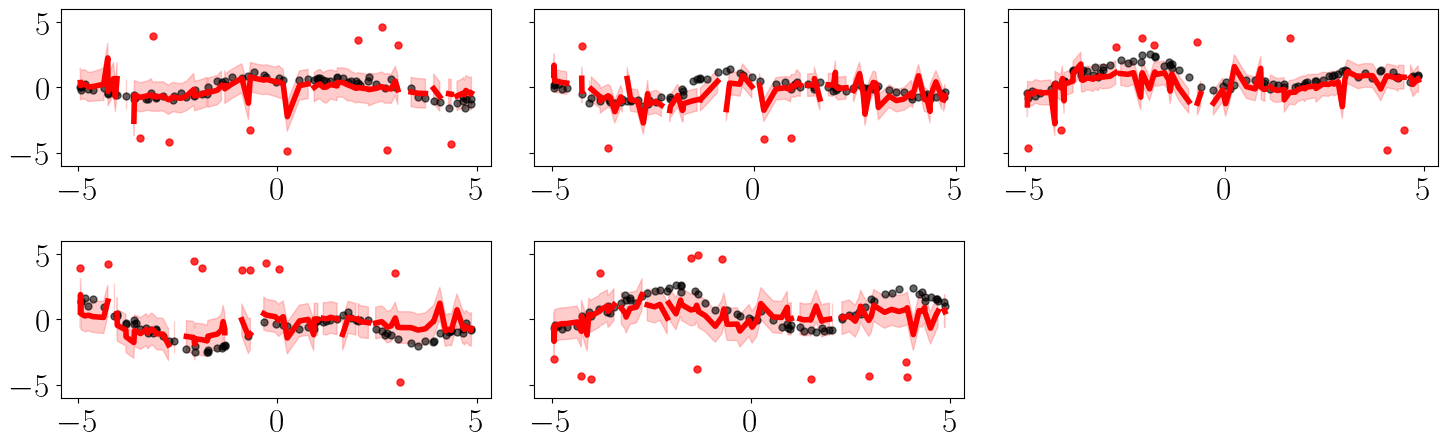

In [19]:
# Plotting
fig, axs = plt.subplots(2, 3, figsize=(15, 5))

for i in range(D):
    ax = axs[i // 3, i % 3]
    # Separate inliers and outliers
    x_all = x_train.flatten()
    y_all = Y_train[:, i]
    is_outlier = outlier_mask[:, i]

    ax.plot(x_all[~is_outlier], y_all[~is_outlier], 'o', color='black', alpha=0.6, label=f'Output {i+1} - inliers')
    ax.plot(x_all[is_outlier], y_all[is_outlier], 'o', color='red', alpha=0.8, label='Outliers')

    ax.plot(x_train.flatten(), predictive_mean[:, i], '-', color='red', label=f'Predictive Mean')
    ax.fill_between(x_train.flatten(), predictive_mean[:, i] - np.sqrt(predictive_variances)[:, i], predictive_mean[:, i] + np.sqrt(predictive_variances)[:, i], color='red', alpha=0.2, label=f'±2 Std. Dev.')

    # ax.plot(x_train.flatten(), initial_predictive_mean[:, i], '-', color='green', label=f'Predictive Mean')
    # ax.fill_between(x_train.flatten(), initial_predictive_mean[:, i] - np.sqrt(initial_predictive_variances)[:, i], initial_predictive_mean[:, i] + np.sqrt(initial_predictive_variances)[:, i], color='green', alpha=0.2, label=f'±2 Std. Dev.')

    ax.set_ylim([-6, 6])
    if i % 3 != 0:
        ax.set_yticklabels([])

# Hide the unused 6th subplot
axs[1, 2].axis('off')

plt.tight_layout()
plt.show()

## MORCGP (RCGP weights)

-553.8678196114589
-553.8678203165574
-553.8678189914933
-553.8678195175221
-553.8678196438422
-553.8678179134054
-553.8678189742635
-553.8678195749087
-553.867819684752
-553.8678196178882
-553.8678196472108
-553.8678196350838
-553.8678196153571
-553.8678195047271
-553.8678195671874
-553.8678195909594
-553.8678194011177
-553.8678195813037
-553.8678195282079
-553.8678196518317
-553.8678196564491
-553.8678193703729
-553.8678195749145
-553.8678195036485
-553.867819747831
-553.8678195395395
-553.8678192237251
-553.8678195993572
-553.8678195719255
-553.8678196180269
-553.8678195435748
-553.8678193024979
-420.6205818624214
-420.6205821117754
-420.620581522163
-420.62058181639287
-420.62058190179386
-420.62058134841163
-420.62058153337216
-420.62058184736827
-420.62058190144785
-420.6205818819002
-420.6205818743137
-420.62058183287076
-420.6205818672144
-420.62058182159336
-420.620581858067
-420.6205818727236
-420.62058184409364
-420.6205818154275
-420.62058183226907
-420.6205819601103
-420.6

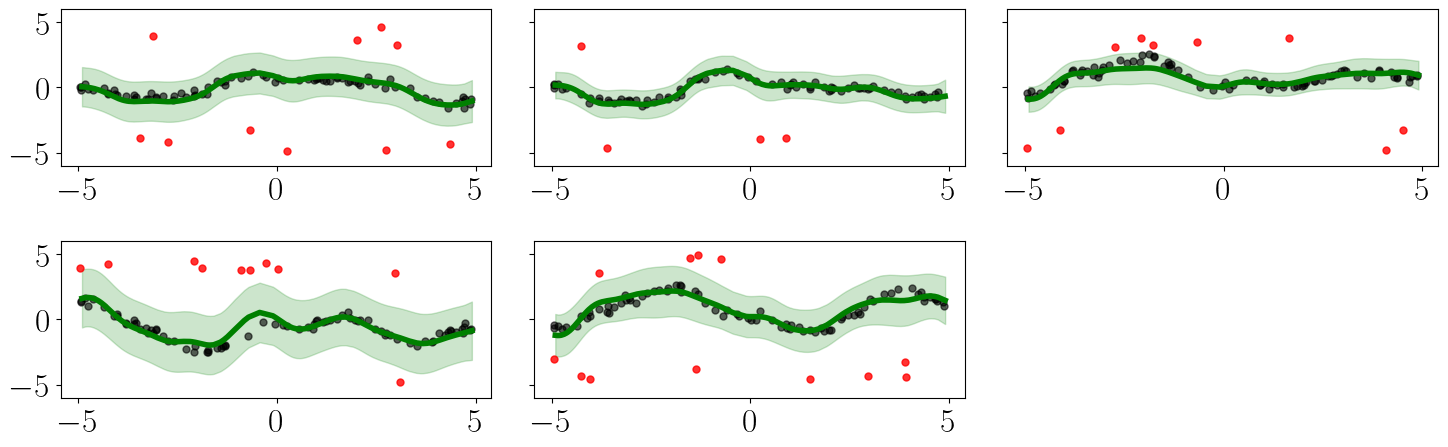

In [20]:
morcgp = MORCGPRegressor_PM(mean=0, length_scale=lengthscale, noise=np.array([0.2]*D), A=A, epsilons=epsilons)
morcgp.fit(x_train, Y_train)

# print(morcgp.loo_cv(length_scale=optim_length_scale, noise=optim_noise, A=A, weighted=False))

morcgp.optimize_loo_cv(weighted=True, print_opt_param = True, print_iter_param=True,
                                                            #    B_weighted=A@A.T, noise_weighted=np.array([0.2]*D)
                                                               )

mu_pm, var_pm = morcgp.predict(x_test)
std_pm = np.sqrt(var_pm + morcgp.noise)

# Plotting
fig, axs = plt.subplots(2, 3, figsize=(15, 5))

for i in range(D):
    ax = axs[i // 3, i % 3]
    # Separate inliers and outliers
    x_all = x_train.flatten()
    y_all = Y_train[:, i]
    is_outlier = outlier_mask[:, i]

    ax.plot(x_all[~is_outlier], y_all[~is_outlier], 'o', color='black', alpha=0.6, label=f'Output {i+1} - inliers')
    ax.plot(x_all[is_outlier], y_all[is_outlier], 'o', color='red', alpha=0.8, label='Outliers')
    ax.plot(x_test.flatten(), mu_pm[:, i], '-', color='Green', label=f'Predicted Mean')
    ax.fill_between(x_test.flatten(), mu_pm[:, i] - 2*std_pm[:, i], mu_pm[:, i] + 2*std_pm[:, i], color='Green', alpha=0.2, label=f'±2 Std. Dev.')
    ax.set_ylim([-6, 6])
    if i % 3 != 0:
        ax.set_yticklabels([])

# Hide the unused 6th subplot
axs[1, 2].axis('off')

plt.tight_layout()
plt.show()

## RCGP

-409.02430553128835
-409.0243057044501
-409.0243020914864
-409.02430550597603
-207.12747915642404
-207.12747919143087
-207.12747816302542
-207.1274791524136
-177.11834627644797
-177.11834628706615
-177.11834575940966
-177.1183462778867
-162.36439815489754
-162.36439815117666
-162.36439797760352
-162.3643981610015
-159.77005756949853
-159.77005756216414
-159.77005751878426
-159.7700575775415
-159.46561150708408
-159.4656114992336
-159.46561150044892
-159.46561151564256
-159.42334760443802
-159.42334759700574
-159.42334760755188
-159.42334761284496
-159.34789219052047
-159.34789218505296
-159.34789220437975
-159.34789219803676
-159.2577598747885
-159.25775987587664
-159.25775989337492
-159.25775987987782
-159.17887551422828
-159.17887551829196
-159.1788755233007
-159.17887551803852
-159.09388852917752
-159.09388853468263
-159.0938885168392
-159.09388853117144
-159.06698190970533
-159.06698191484725
-159.06698189590813
-159.06698191115134
-158.99593159455944
-158.99593159625374
-158.99593

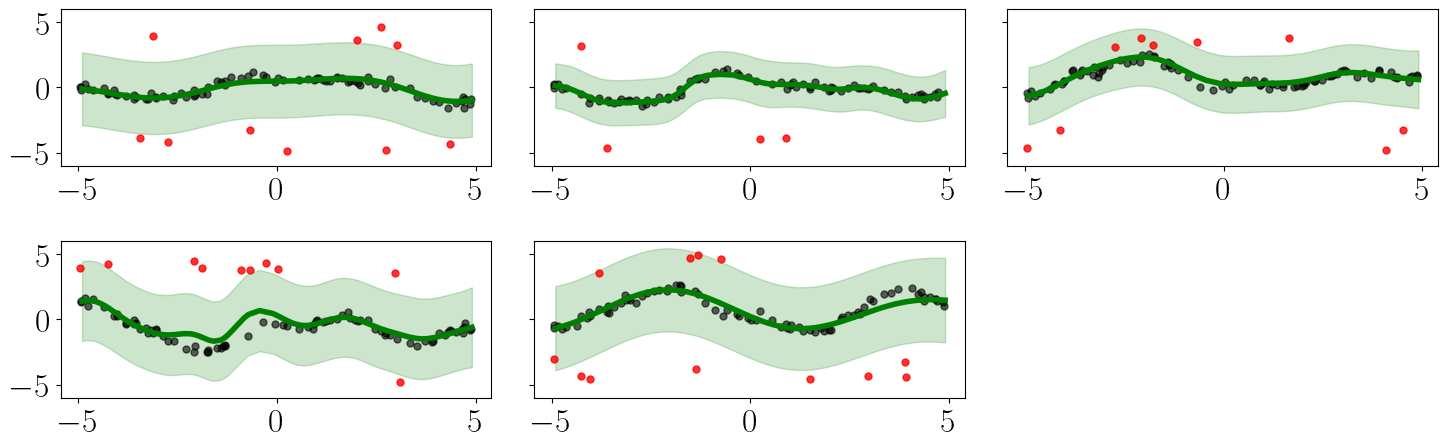

In [21]:
prior_mean = ConstantMean(constant=0.0)

mu_rcgp, std_rcgp = np.full_like(Y_test, np.nan), np.full_like(Y_test, np.nan)

for d in range(D):
    rcgp = RCGPRegressor(mean=prior_mean, length_scale=lengthscale, rbf_variance=rbf_variance, noise=noise_var, epsilon=epsilon)
    rcgp.fit(x_train[~np.isnan(Y_train[:, d])], Y_train[:, d][~np.isnan(Y_train[:, d])].reshape(-1, 1))

    rcgp.optimize_loo_cv(print_opt_param=True, print_iter_param=True, weighted=False)

    mu_rcgp[:, d], var_rcgp = rcgp.predict(x_test)
    std_rcgp[:, d] = np.sqrt(var_rcgp + rcgp.noise)

# Plotting
fig, axs = plt.subplots(2, 3, figsize=(15, 5))

for i in range(D):
    ax = axs[i // 3, i % 3]
    # Separate inliers and outliers
    x_all = x_train.flatten()
    y_all = Y_train[:, i]
    is_outlier = outlier_mask[:, i]

    ax.plot(x_all[~is_outlier], y_all[~is_outlier], 'o', color='black', alpha=0.6, label=f'Output {i+1} - inliers')
    ax.plot(x_all[is_outlier], y_all[is_outlier], 'o', color='red', alpha=0.8, label='Outliers')
    ax.plot(x_test.flatten(), mu_rcgp[:, i], '-', color='Green', label=f'Predicted Mean')
    ax.fill_between(x_test.flatten(), mu_rcgp[:, i] - 2*std_rcgp[:, i], mu_rcgp[:, i] + 2*std_rcgp[:, i], color='Green', alpha=0.2, label=f'±2 Std. Dev.')
    ax.set_ylim([-6, 6])
    if i % 3 != 0:
        ax.set_yticklabels([])

# Hide the unused 6th subplot
axs[1, 2].axis('off')

plt.tight_layout()
plt.show()

## Combined

In [22]:
def calculate_rmse(y_true, y_pred):
    errors = y_true - y_pred
    squared_errors = errors ** 2
    mse = np.mean(squared_errors)
    rmse = np.sqrt(mse)
    return rmse

def nlpd(Y_true, mu_pred, var_pred):
    # Avoid zero or negative variances by adding a small number epsilon if needed
    epsilon = 1e-10
    var_pred = np.maximum(var_pred, epsilon)
    
    # Compute NLPD per test point
    nlpd_values = 0.5 * np.log(2 * np.pi * var_pred) + ((Y_true - mu_pred) ** 2) / (2 * var_pred)
    
    # Average NLPD over all test points
    return np.mean(nlpd_values)

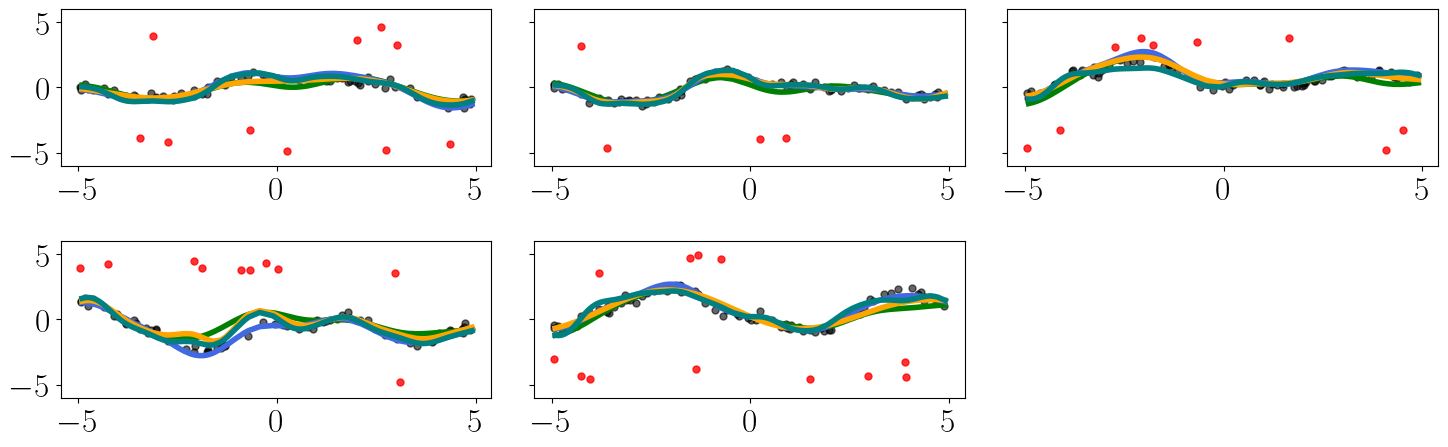

In [24]:
# Plotting
fig, axs = plt.subplots(2, 3, figsize=(15, 5))

for i in range(D):
    ax = axs[i // 3, i % 3]
    # Separate inliers and outliers
    x_all = x_train.flatten()
    y_all = Y_train[:, i]
    is_outlier = outlier_mask[:, i]

    ax.plot(x_all[~is_outlier], y_all[~is_outlier], 'o', color='black', alpha=0.6, label=f'Output {i+1} - inliers')
    ax.plot(x_all[is_outlier], y_all[is_outlier], 'o', color='red', alpha=0.8, label='Outliers')

    # MOGP
    ax.plot(x_test.flatten(), mu_mogp[:, i], '-', color='Green', label=f'Predicted Mean')
    # ax.fill_between(x_test.flatten(), mu_mogp[:, i] - 2*std_mogp[:, i], mu_mogp[:, i] + 2*std_mogp[:, i], color='Blue', alpha=0.2, label=f'±2 Std. Dev.')

    # MORCGP
    ax.plot(x_test.flatten(), mu_morcgp[:, i], '-', color='RoyalBlue', label=f'Predicted Mean')
    # ax.fill_between(x_test.flatten(), mu_morcgp[:, i] - 2*std_morcgp[:, i], mu_morcgp[:, i] + 2*std_morcgp[:, i], color='Green', alpha=0.2, label=f'±2 Std. Dev.')

    # RCGP
    ax.plot(x_test.flatten(), mu_rcgp[:, i], '-', color='Orange', label=f'Predicted Mean')
    # ax.fill_between(x_test.flatten(), mu_rcgp[:, i] - 2*std_rcgp[:, i], mu_rcgp[:, i] + 2*std_rcgp[:, i], color='Red', alpha=0.2, label=f'±2 Std. Dev.')

    # MORCGP (RCGP weights)
    ax.plot(x_test.flatten(), mu_pm[:, i], '-', color='Teal', label=f'Predicted Mean')
    # ax.fill_between(x_test.flatten(), mu_pm[:, i] - 2*std_pm[:, i], mu_pm[:, i] + 2*std_pm[:, i], color='Teal', alpha=0.2, label=f'±2 Std. Dev.')

    ax.set_ylim([-6, 6])
    if i % 3 != 0:
        ax.set_yticklabels([])

# Hide the unused 6th subplot
axs[1, 2].axis('off')

plt.tight_layout()
plt.show()

In [25]:
rmse_mogp = calculate_rmse(Y_test, mu_mogp)
rmse_morcgp = calculate_rmse(Y_test, mu_morcgp)
rmse_rcgp = calculate_rmse(Y_test, mu_rcgp)
rmse_pm = calculate_rmse(Y_test, mu_pm)

print("RMSE MOGP:", rmse_mogp)
print("RMSE MORCGP:", rmse_morcgp)
print("RMSE RCGP:", rmse_rcgp)
print("RMSE MORCGP (PM):", rmse_pm)

nlpd_mogp = nlpd(Y_test, mu_mogp, std_mogp**2)
nlpd_morcgp = nlpd(Y_test, mu_morcgp, std_morcgp**2)
nlpd_rcgp = nlpd(Y_test, mu_rcgp, std_rcgp**2)
nlpd_pm = nlpd(Y_test, mu_pm, std_pm**2)

print("NLPD MOGP:", nlpd_mogp)
print("NLPD MORCGP:", nlpd_morcgp)
print("NLPD RCGP:", nlpd_rcgp)
print("NLPD MORCGP (PM):", nlpd_pm)

RMSE MOGP: 0.4932593611037036
RMSE MORCGP: 0.28076417573152246
RMSE RCGP: 0.3685104769193933
RMSE MORCGP (PM): 0.37565060815362084
NLPD MOGP: 1.227217901361468
NLPD MORCGP: 0.820942613476478
NLPD RCGP: 1.1846959279394687
NLPD MORCGP (PM): 0.7316485510560967


# No outliers

[10  4  9 10 12]


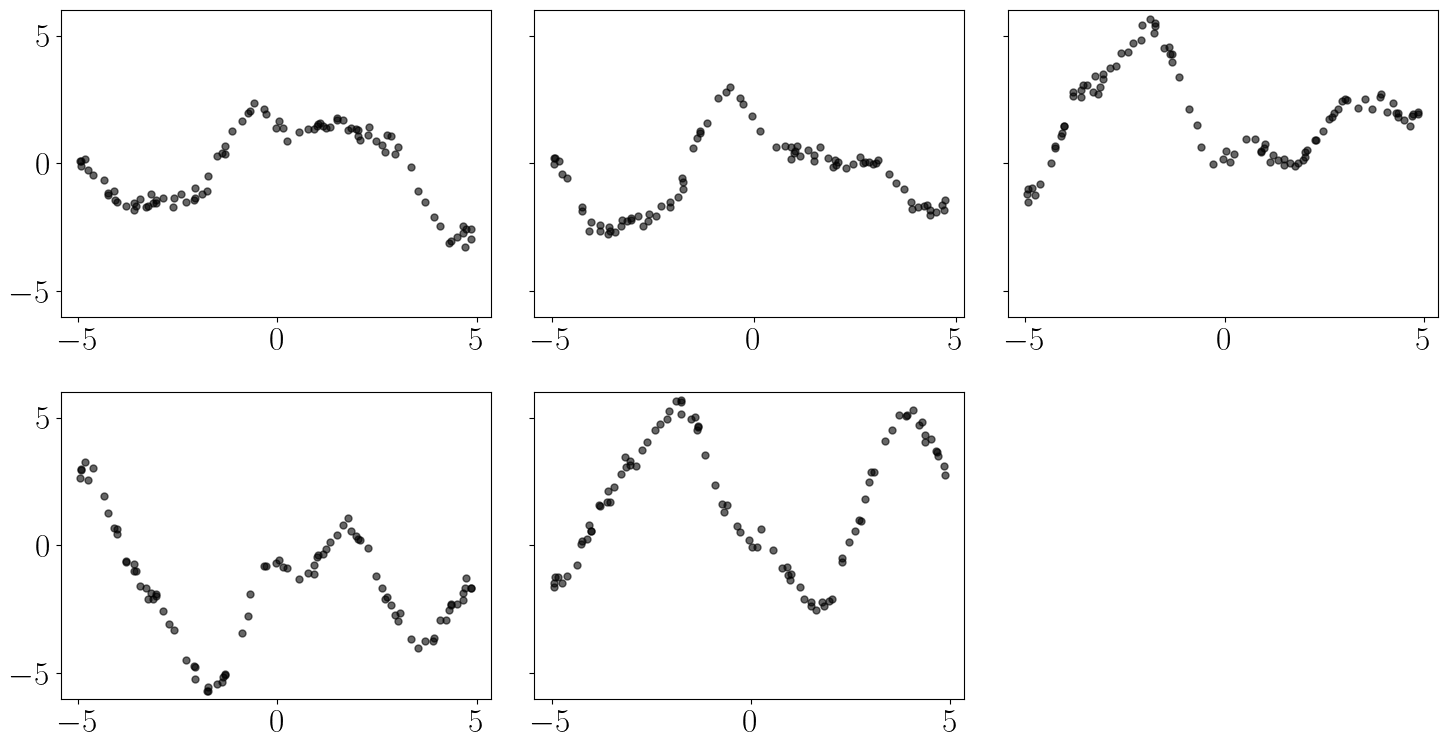

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import cholesky

np.random.seed(42)
train_test_N = 300
N = 100
D = 5  # changed to 5 outputs
noise_var = 0.5
missing_percentage = 0.1 
epsilon = 0.1

lengthscale = 1.0
rbf_variance = 5

x = np.sort(np.random.uniform(-5, 5, train_test_N)).reshape(-1, 1)

# Define a 5x5 coregionalization matrix B (symmetric and PSD)
B = np.array([
    [1.0,  0.9,  -0.7,  0.5,  -0.6],
    [0.9,  1.0,  -0.8,  0.6,  -0.7],
    [-0.7, -0.8,  1.0, -0.9,   0.8],
    [0.5,  0.6,  -0.9,  1.0,  -0.85],
    [-0.6, -0.7,  0.8, -0.85,  1.0]
])

A = np.linalg.cholesky(B)

Kx = rbf_kernel(x, x, lengthscale=lengthscale, variance=rbf_variance)
K = np.kron(B, Kx)

# Add a small jitter for numerical stability
L = cholesky(K + 1e-6*np.eye(D*train_test_N), lower=True)

f_samples = L @ np.random.randn(D*train_test_N)
F = f_samples.reshape(D, train_test_N).T
Y = F + np.random.normal(0, noise_var, F.shape)

x_train, Y_train, x_test, Y_test = train_test_split_random(x, Y, N)
Y_train = introduce_missing_values(Y_train, missing_percentage)

outliers_per_channel = np.bincount(indices[1])
non_nan_counts = np.sum(~np.isnan(Y_train), axis=0)

epsilons = outliers_per_channel / non_nan_counts

print(outliers_per_channel)

# Plotting in 2 rows and 3 columns
fig, axs = plt.subplots(2, 3, figsize=(15, 8))

for i in range(D):
    ax = axs[i // 3, i % 3]
    
    ax.plot(x_train, Y_train[:, i], 'o', color='black', alpha=0.6, label=f'Output {i+1} - inliers')

    ax.set_ylim([-6, 6])
    if i % 3 != 0:
        ax.set_yticklabels([])

# Hide the unused 6th subplot
axs[1, 2].axis('off')

plt.tight_layout()
plt.show()

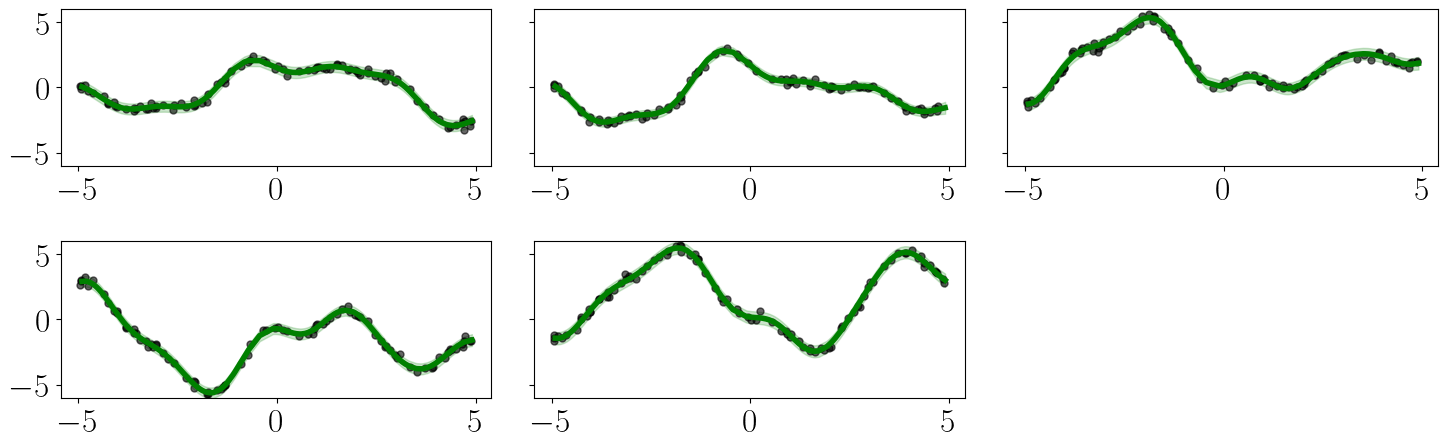

In [38]:
mogp = MOGPRegressor(mean=0, length_scale=1.0, noise = np.array([0.2] * D), A = 2*A)
# mogp = MOGPRegressor_NC(mean=0, length_scale=1.0, noise = 0.2, A = 2*A)
mogp.fit(x_train, Y_train)

mogp.optimize_hyperparameters(
    # print_opt_param=True, print_iter_param=True
    )
# mogp.optimize_loo_cv(print_opt_param=True, print_iter_param=True)

optim_A = mogp.A
optim_noise = mogp.noise
optim_B = optim_A @ optim_A.T
optim_length_scale = mogp.length_scale

# Predict on test points
mu_mogp, var_mogp = mogp.predict(x_test)
std_mogp = np.sqrt(var_mogp + mogp.noise)

# Plotting
fig, axs = plt.subplots(2, 3, figsize=(15, 5))

for i in range(D):
    ax = axs[i // 3, i % 3]

    ax.plot(x_train, Y_train[:, i], 'o', color='black', alpha=0.6, label=f'Output {i+1} - inliers')
    ax.plot(x_test.flatten(), mu_mogp[:, i], '-', color='Green', label=f'Predicted Mean')
    ax.fill_between(x_test.flatten(), mu_mogp[:, i] - 2*std_mogp[:, i], mu_mogp[:, i] + 2*std_mogp[:, i], color='Green', alpha=0.2, label=f'±2 Std. Dev.')
    ax.set_ylim([-6, 6])
    if i % 3 != 0:
        ax.set_yticklabels([])

# Hide the unused 6th subplot
axs[1, 2].axis('off')

plt.tight_layout()
plt.show()

-244.90515752871684
-244.9051587293191
-244.9051578954694
-244.90515805162596
-244.90515791721515
-244.90515797208008
-244.90515810605373
-244.90515743281856
-244.9051575654659
-244.90515792174637
-244.9051569110369
-244.90515809843558
-244.90515754686635
-244.9051573700552
-244.90515562699147
-244.90515852480004
-244.9051561646791
-244.90515766898608
-244.90515795796262
-244.90515626896854
-244.90515733789124
-244.90515692220197
-244.9051578145402
-244.90515781211786
-244.9051573124651
-244.90515723383464
-244.9051569912038
-244.90515778434585
-244.90515715780145
-244.90515664323226
-244.90515795087518
-244.90515650133014
-211.34094261530956
-211.34094227975288
-211.3409430776671
-211.34094308622582
-211.34094296925443
-211.34094321685555
-211.34094300653953
-211.3409426202297
-211.34094397908788
-211.34094208503947
-211.34094399224878
-211.34094272881777
-211.34094253248384
-211.34094178827266
-211.34094296954694
-211.34094179927473
-211.34094264131335
-211.3409425643014
-211.3409419

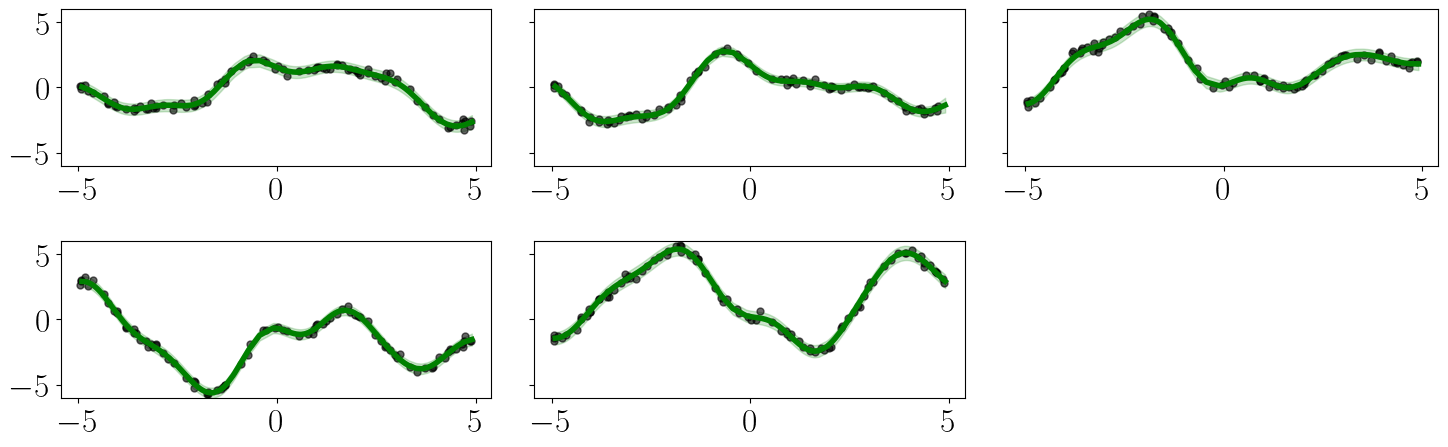

In [39]:
# morcgp = MORCGPRegressor_NC_fixed_weights(mean = 0, length_scale=optim_length_scale, noise = optim_noise, A=A)
morcgp = MORCGPRegressor_fixed_weights(mean = 0, length_scale=lengthscale, noise = np.array([noise_var]*D), A=A)
# morcgp = MORCGPRegressor(mean=0, length_scale=lengthscale, noise=np.array([0.2]*D), A=A)
initial_predictive_mean, initial_predictive_variances = morcgp.fit(x_train, Y_train, 
                                                                   B_weighted=optim_B, noise_weighted=optim_noise
                                                                   )

# print(morcgp.loo_cv(length_scale=optim_length_scale, noise=optim_noise, A=A, weighted=False))

# Optimize hyperparameters
predictive_mean, predictive_variances = morcgp.optimize_loo_cv(weighted=True, print_opt_param = True, print_iter_param=True, update_weights=True
                                                            #    B_weighted=A@A.T, noise_weighted=np.array([0.2]*D)
                                                               )

mu_morcgp, var_morcgp = morcgp.predict(x_test)
std_morcgp = np.sqrt(var_morcgp + morcgp.noise)

# Plotting
fig, axs = plt.subplots(2, 3, figsize=(15, 5))

for i in range(D):
    ax = axs[i // 3, i % 3]
    ax.plot(x_train, Y_train[:, i], 'o', color='black', alpha=0.6, label=f'Output {i+1} - inliers')
    ax.plot(x_test.flatten(), mu_morcgp[:, i], '-', color='Green', label=f'Predicted Mean')
    ax.fill_between(x_test.flatten(), mu_morcgp[:, i] - 2*std_morcgp[:, i], mu_morcgp[:, i] + 2*std_morcgp[:, i], color='Green', alpha=0.2, label=f'±2 Std. Dev.')
    ax.set_ylim([-6, 6])
    if i % 3 != 0:
        ax.set_yticklabels([])

# Hide the unused 6th subplot
axs[1, 2].axis('off')

plt.tight_layout()
plt.show()

-136.9406964376325
-136.94069737324395
-136.94069676745292
-136.94069675610902
-136.94069665998208
-136.94069676315988
-136.9406967018908
-136.94069639367154
-136.94069656009685
-136.94069648014943
-136.94069633461208
-136.94069664624143
-136.94069645633797
-136.9406962611895
-136.9406958025389
-136.94069650831855
-136.9406958016476
-136.94069648941948
-136.94069650996772
-136.94069571964928
-136.94069628468753
-136.94069594347638
-136.94069653362718
-136.94069640810545
-136.94069605308158
-136.94069632637922
-136.94069596926747
-136.94069652911443
-136.9406962890608
-136.94069607224068
-136.94069645478697
-136.94069594936133
-103.15454951686756
-103.15454918953986
-103.15454982348217
-103.1545498240465
-103.15454977183049
-103.15454984138422
-103.15454975844575
-103.15454955792687
-103.15454949840556
-103.1545495179405
-103.15454958215004
-103.15454951829715
-103.15454949957875
-103.1545495346108
-103.15454952548583
-103.15454952882082
-103.15454953223015
-103.1545494927362
-103.15454

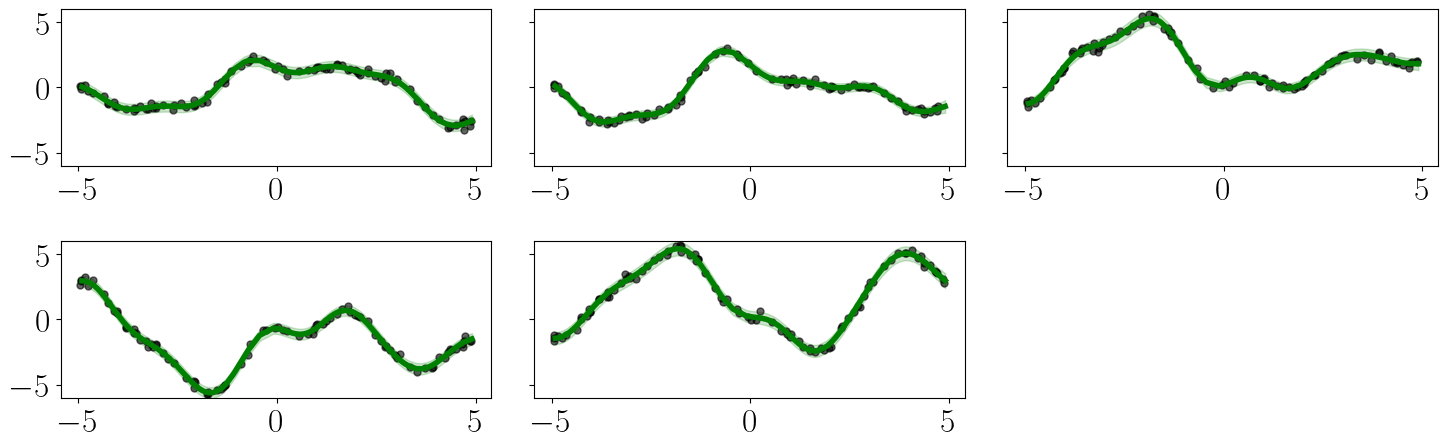

In [41]:
morcgp = MORCGPRegressor_PM(mean=0, length_scale=lengthscale, noise=np.array([0.2]*D), A=A, epsilons=[0]*D)
morcgp.fit(x_train, Y_train)

# print(morcgp.loo_cv(length_scale=optim_length_scale, noise=optim_noise, A=A, weighted=False))

morcgp.optimize_loo_cv(weighted=True, print_opt_param = True, print_iter_param=True,
                                                            #    B_weighted=A@A.T, noise_weighted=np.array([0.2]*D)
                                                               )

mu_pm, var_pm = morcgp.predict(x_test)
std_pm = np.sqrt(var_pm + morcgp.noise)

# Plotting
fig, axs = plt.subplots(2, 3, figsize=(15, 5))

for i in range(D):
    ax = axs[i // 3, i % 3]
    ax.plot(x_train, Y_train[:, i], 'o', color='black', alpha=0.6, label=f'Output {i+1} - inliers')
    ax.plot(x_test.flatten(), mu_pm[:, i], '-', color='Green', label=f'Predicted Mean')
    ax.fill_between(x_test.flatten(), mu_pm[:, i] - 2*std_pm[:, i], mu_pm[:, i] + 2*std_pm[:, i], color='Green', alpha=0.2, label=f'±2 Std. Dev.')
    ax.set_ylim([-6, 6])
    if i % 3 != 0:
        ax.set_yticklabels([])

# Hide the unused 6th subplot
axs[1, 2].axis('off')

plt.tight_layout()
plt.show()

-27.66823041538134
-27.668230429397195
-27.66823077427359
-27.66823041521583
1.709321611050395
1.70932166581368
1.7093214053443966
1.7093216058750076
-209.98761520555973
-209.98761836209468
-209.9876127802962
-209.9876149410898
5.442463045903397
5.442462999120475
5.442462888455616
5.442463049940627
4.770567318988432
4.770567439353687
4.770567526812846
4.770567310002267
8.934580761879726
8.934580818089309
8.934580747964482
8.934580757483822
9.081476511319902
9.081476490156522
9.081476519434686
9.081476513432204
9.100426898989035
9.100426905328684
9.100426898599927
9.100426898827823
9.101660683999967
9.101660684158713
9.101660683671675
9.101660684349673
9.10168119418081
9.101681194190704
9.101681194251944
9.101681194544668
9.101710788946619
9.101710788909822
9.101710789030749
9.101710789313698
9.10182699800697
9.10182699777719
9.101826998138467
9.101826998386564
9.102256902111971
9.102256901105592
9.1022569024351
9.102256902548753
9.106650413043758
9.106650407217229
9.106650414450804
9.1

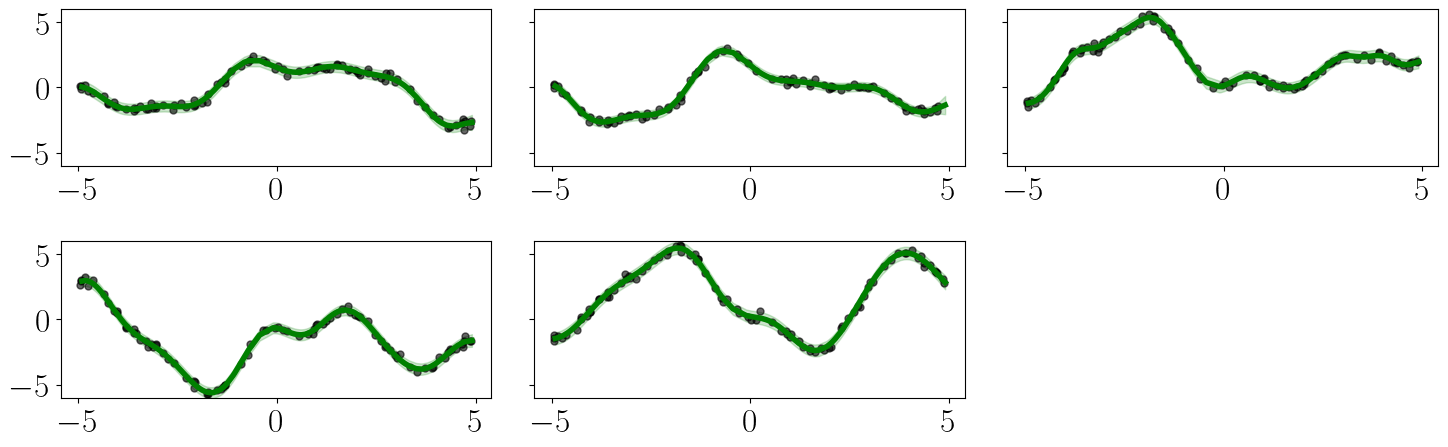

In [43]:
prior_mean = ConstantMean(constant=0.0)

mu_rcgp, std_rcgp = np.full_like(Y_test, np.nan), np.full_like(Y_test, np.nan)

for d in range(D):
    rcgp = RCGPRegressor(mean=prior_mean, length_scale=lengthscale, rbf_variance=rbf_variance, noise=noise_var, epsilon=0)
    rcgp.fit(x_train[~np.isnan(Y_train[:, d])], Y_train[:, d][~np.isnan(Y_train[:, d])].reshape(-1, 1))

    rcgp.optimize_loo_cv(print_opt_param=True, print_iter_param=True, weighted=False)

    mu_rcgp[:, d], var_rcgp = rcgp.predict(x_test)
    std_rcgp[:, d] = np.sqrt(var_rcgp + rcgp.noise)

# Plotting
fig, axs = plt.subplots(2, 3, figsize=(15, 5))

for i in range(D):
    ax = axs[i // 3, i % 3]
    ax.plot(x_train, Y_train[:, i], 'o', color='black', alpha=0.6, label=f'Output {i+1} - inliers')
    ax.plot(x_test.flatten(), mu_rcgp[:, i], '-', color='Green', label=f'Predicted Mean')
    ax.fill_between(x_test.flatten(), mu_rcgp[:, i] - 2*std_rcgp[:, i], mu_rcgp[:, i] + 2*std_rcgp[:, i], color='Green', alpha=0.2, label=f'±2 Std. Dev.')
    ax.set_ylim([-6, 6])
    if i % 3 != 0:
        ax.set_yticklabels([])

# Hide the unused 6th subplot
axs[1, 2].axis('off')

plt.tight_layout()
plt.show()

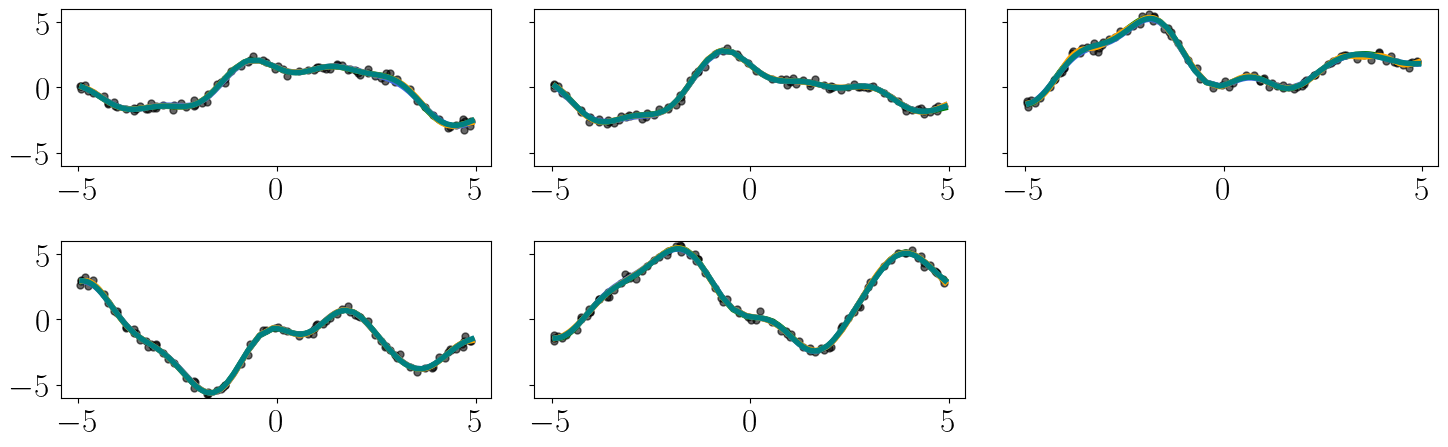

In [44]:
# Plotting
fig, axs = plt.subplots(2, 3, figsize=(15, 5))

for i in range(D):
    ax = axs[i // 3, i % 3]
    ax.plot(x_train, Y_train[:, i], 'o', color='black', alpha=0.6, label=f'Output {i+1} - inliers')

    # MOGP
    ax.plot(x_test.flatten(), mu_mogp[:, i], '-', color='Green', label=f'Predicted Mean')
    # ax.fill_between(x_test.flatten(), mu_mogp[:, i] - 2*std_mogp[:, i], mu_mogp[:, i] + 2*std_mogp[:, i], color='Blue', alpha=0.2, label=f'±2 Std. Dev.')

    # MORCGP
    ax.plot(x_test.flatten(), mu_morcgp[:, i], '-', color='RoyalBlue', label=f'Predicted Mean')
    # ax.fill_between(x_test.flatten(), mu_morcgp[:, i] - 2*std_morcgp[:, i], mu_morcgp[:, i] + 2*std_morcgp[:, i], color='Green', alpha=0.2, label=f'±2 Std. Dev.')

    # RCGP
    ax.plot(x_test.flatten(), mu_rcgp[:, i], '-', color='Orange', label=f'Predicted Mean')
    # ax.fill_between(x_test.flatten(), mu_rcgp[:, i] - 2*std_rcgp[:, i], mu_rcgp[:, i] + 2*std_rcgp[:, i], color='Red', alpha=0.2, label=f'±2 Std. Dev.')

    # MORCGP (RCGP weights)
    ax.plot(x_test.flatten(), mu_pm[:, i], '-', color='Teal', label=f'Predicted Mean')
    # ax.fill_between(x_test.flatten(), mu_pm[:, i] - 2*std_pm[:, i], mu_pm[:, i] + 2*std_pm[:, i], color='Teal', alpha=0.2, label=f'±2 Std. Dev.')

    ax.set_ylim([-6, 6])
    if i % 3 != 0:
        ax.set_yticklabels([])

# Hide the unused 6th subplot
axs[1, 2].axis('off')

plt.tight_layout()
plt.show()

In [45]:
rmse_mogp = calculate_rmse(Y_test, mu_mogp)
rmse_morcgp = calculate_rmse(Y_test, mu_morcgp)
rmse_rcgp = calculate_rmse(Y_test, mu_rcgp)
rmse_pm = calculate_rmse(Y_test, mu_pm)

print("RMSE MOGP:", rmse_mogp)
print("RMSE MORCGP:", rmse_morcgp)
print("RMSE RCGP:", rmse_rcgp)
print("RMSE MORCGP (PM):", rmse_pm)

nlpd_mogp = nlpd(Y_test, mu_mogp, std_mogp**2)
nlpd_morcgp = nlpd(Y_test, mu_morcgp, std_morcgp**2)
nlpd_rcgp = nlpd(Y_test, mu_rcgp, std_rcgp**2)
nlpd_pm = nlpd(Y_test, mu_pm, std_pm**2)

print("NLPD MOGP:", nlpd_mogp)
print("NLPD MORCGP:", nlpd_morcgp)
print("NLPD RCGP:", nlpd_rcgp)
print("NLPD MORCGP (PM):", nlpd_pm)

RMSE MOGP: 0.2172573741345879
RMSE MORCGP: 0.22090687407192133
RMSE RCGP: 0.22034380033709763
RMSE MORCGP (PM): 0.2202201828434661
NLPD MOGP: -0.09578570034767732
NLPD MORCGP: -0.0819576757436838
NLPD RCGP: -0.08197742990356491
NLPD MORCGP (PM): -0.08557983908925869
